# MODELLING MOVEMENT OF PEOPLE

In [1]:
# allows to import own functions
import sys, os
path_name = os.getcwd()
root_project = os.path.split(path_name)[0]
sys.path.append(root_project)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.help_func import extract_indicator, last_values
import plotly.express as px
from sklearn import preprocessing
from ast import literal_eval
import networkx as nx

sns.set()

In [3]:
pd.set_option('max_rows', 100)

In [4]:
pd.reset_option("display.max_rows")

In [5]:
df = pd.read_pickle('../data/interim/country_info.gpickle')
df

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,NaN,NaN,33.0000,65.0000,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
1,Albania,ALB,2866376.0,5340000.0,5415000.0,41.0000,20.0000,0.003759,0.004280,1.862980,1.889145,Europe,EU,"[GRC, ITA, GBR, DEU, SVN, AUT, TUR]"
2,Algeria,DZA,42228429.0,2657000.0,5610000.0,28.0000,3.0000,0.001870,0.004434,0.062920,0.132849,Africa,AF,"[DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ..."
3,American Samoa,ASM,64948.0,20200.0,NaN,-14.3333,-170.0000,0.000014,NaN,0.311018,NaN,Oceania,OC,[USA]
4,Andorra,AND,1198575.0,3042000.0,NaN,42.5000,1.6000,0.002141,NaN,2.538014,NaN,Europe,EU,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,Virgin Islands (U.S.),VIR,106977.0,381000.0,NaN,18.3333,-64.8333,0.000268,NaN,3.561513,NaN,North America,NaN,"[VGB, PRI, USA, AIA, DMA, KNA]"
214,West Bank and Gaza,PSE,4569087.0,606000.0,NaN,32.0000,35.2500,0.000427,NaN,0.132630,NaN,Asia,AS,NaN
215,"Yemen, Rep.",YEM,28498687.0,366700.0,NaN,15.0000,48.0000,0.000258,NaN,0.012867,NaN,Asia,AS,"[ARE, SAU, SOM, DJI, BHR, JOR, IND, EGY, QAT, ..."
216,Zambia,ZMB,17351822.0,1072000.0,NaN,-15.0000,30.0000,0.000755,NaN,0.061780,NaN,Africa,AF,"[NLD, ZWE, MWI, KEN, ZAF, BWA, AGO, ARE, ETH, ..."


In [6]:
# df = pd.read_csv('/Users/agm/Documents/KSchool/TFM/data_out/fulldataset_agm.csv')
# df

## DEPARTURES

In [7]:
departures_year_i = df[['departures', 'country_code']]
departures_year_i

,departures,country_code
0,NaN,AFG
1,5415000.0,ALB
2,5610000.0,DZA
3,NaN,ASM
4,NaN,AND
...,...,...
213,NaN,VIR
214,NaN,PSE
215,NaN,YEM
216,NaN,ZMB


In [8]:
departures_year_i.isna().sum()

departures      82
country_code     0
dtype: int64

¿De que paises no tengo los departures?

In [9]:
df_nan= df.loc[df['departures'].isna(), 'country_code']
df_nan

0      AFG
3      ASM
4      AND
6      ATG
10     ABW
      ... 
212    VNM
213    VIR
214    PSE
215    YEM
216    ZMB
Name: country_code, Length: 82, dtype: object

Podría substituir los nan por la mediana de la distribución de departures, pero tendría países que apenas tendrán viajeros en la realidad con un número por encima...

Puedo ponderar por PIB

In [10]:
df2 = pd.read_csv('../data/raw/world_indicators_data.csv')
df_gdp = extract_indicator(df2, 'GDP per capita, PPP (constant 2011 international $)')
df_gdp2 = extract_indicator(df2, 'GDP (current US$)')

In [11]:
df_gdp = last_values(df_gdp)
df_gdp2 = last_values(df_gdp2)

In [12]:
df_gdp

,Country Name,Country Code,last_value
0,Arab World,ARB,15590.398354
1,Caribbean small states,CSS,14363.206930
2,Central Europe and the Baltics,CEB,27832.286723
3,Early-demographic dividend,EAR,9121.174571
4,East Asia & Pacific,EAS,17244.834092
...,...,...,...
259,Virgin Islands (U.S.),VIR,NaN
260,West Bank and Gaza,PSE,4576.432497
261,"Yemen, Rep.",YEM,2284.970504
262,Zambia,ZMB,3747.972455


In [13]:
df_gdp2

,Country Name,Country Code,last_value
0,Arab World,ARB,2.774315e+12
1,Caribbean small states,CSS,7.352354e+10
2,Central Europe and the Baltics,CEB,1.632913e+12
3,Early-demographic dividend,EAR,1.163806e+13
4,East Asia & Pacific,EAS,2.594241e+13
...,...,...,...
259,Virgin Islands (U.S.),VIR,3.855000e+09
260,West Bank and Gaza,PSE,1.461590e+10
261,"Yemen, Rep.",YEM,2.691440e+10
262,Zambia,ZMB,2.672007e+10


In [14]:
df_gdp.isna().sum()

Country Name     0
Country Code     0
last_value      21
dtype: int64

In [15]:
df_gdp2.isna().sum()

Country Name    0
Country Code    0
last_value      6
dtype: int64

Veo que tengo más valores del GDP crudo. Me quedo con él. Y solo con los paises.

In [16]:
df_gdp2 = df_gdp2.loc[df_gdp2['Country Code'].isin(df['country_code'].values)]
df_gdp2.reset_index(inplace = True, drop = True)
df_gdp2

,Country Name,Country Code,last_value
0,Afghanistan,AFG,1.936297e+10
1,Albania,ALB,1.510250e+10
2,Algeria,DZA,1.737580e+11
3,American Samoa,ASM,6.360000e+08
4,Andorra,AND,3.236544e+09
...,...,...,...
206,Virgin Islands (U.S.),VIR,3.855000e+09
207,West Bank and Gaza,PSE,1.461590e+10
208,"Yemen, Rep.",YEM,2.691440e+10
209,Zambia,ZMB,2.672007e+10


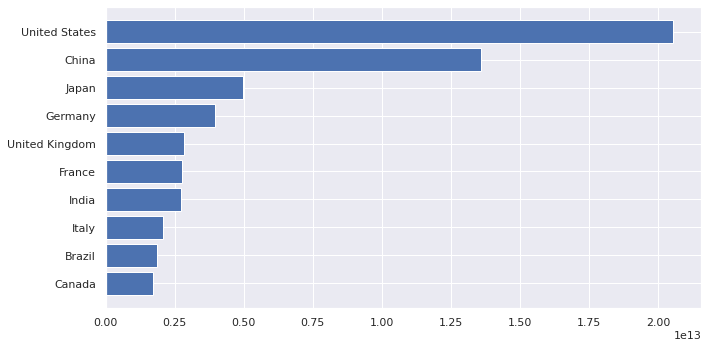

In [17]:
df_gdp2 = df_gdp2.sort_values(by = 'last_value', ascending = False)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.barh(df_gdp2['Country Name'][:10][::-1], df_gdp2['last_value'][:10][::-1])
plt.tight_layout()

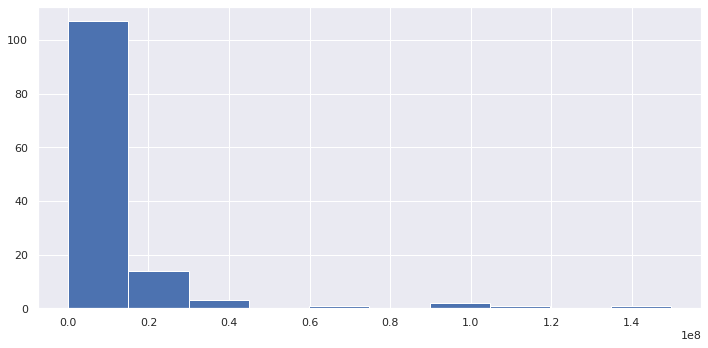

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.hist(np.array(departures_year_i['departures'].dropna()))
plt.tight_layout()

Utilizo la mediana porque es robusta.

In [19]:
departures_median = np.median(np.array(departures_year_i['departures'].dropna()))
departures_median

2244000.0

Necesito para cada valor nan, ponderar la mediana según el PIB (GDP).

¿Cual es el gdp de los paises que tengo nan?

In [20]:
df_gdp2 = df_gdp2.loc[df_gdp2['Country Code'].isin(df_nan.values)].dropna()
df_gdp2

,Country Name,Country Code,last_value
141,Nigeria,NGA,3.972696e+11
173,South Africa,ZAF,3.682889e+11
146,Pakistan,PAK,3.145882e+11
205,Vietnam,VNM,2.452137e+11
90,Iraq,IRQ,2.242280e+11
...,...,...,...
162,Sao Tome and Principe,STP,4.222968e+08
125,"Micronesia, Fed. Sts.",FSM,4.019323e+08
121,Marshall Islands,MHL,2.212780e+08
100,Kiribati,KIR,1.882845e+08


In [21]:
gdp = df_gdp2['last_value'].values
gdp

array([3.97269616e+11, 3.68288940e+11, 3.14588211e+11, 2.45213686e+11,
       2.24228010e+11, 1.91362088e+11, 8.79082625e+10, 7.12148034e+10,
       6.55564640e+10, 5.66391556e+10, 5.05972891e+10, 5.04999216e+10,
       4.30070478e+10, 3.86752053e+10, 2.69144022e+10, 2.67200734e+10,
       2.41295996e+10, 2.01618654e+10, 1.93629696e+10, 1.86160189e+10,
       1.71634328e+10, 1.57139088e+10, 1.47172232e+10, 1.46159000e+10,
       1.45217116e+10, 1.41247751e+10, 1.35673512e+10, 1.34323770e+10,
       1.30667491e+10, 1.26721311e+10, 1.24245000e+10, 1.09072150e+10,
       1.03542746e+10, 9.65872117e+09, 9.50871560e+09, 7.18484419e+09,
       7.06497118e+09, 6.77053282e+09, 6.21463365e+09, 5.92000000e+09,
       5.50416667e+09, 5.35872298e+09, 5.23481793e+09, 5.14500000e+09,
       5.14183391e+09, 4.72072728e+09, 3.87866262e+09, 3.85500000e+09,
       3.59075377e+09, 3.26400000e+09, 3.23654391e+09, 2.95591223e+09,
       2.73878628e+09, 2.70714678e+09, 2.70055866e+09, 2.68915727e+09,
      

In [22]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0.5, 2))

In [23]:
gdp.shape

(80,)

In [24]:
gdp.reshape(-1,1).shape

(80, 1)

In [25]:
gdp_normalized = min_max_scaler.fit_transform(gdp.reshape(-1,1))
gdp_normalized

array([[2.        ],
       [1.89054092],
       [1.687715  ],
       [1.42568967],
       [1.34642745],
       [1.22229392],
       [0.83155217],
       [0.76850151],
       [0.74713015],
       [0.71344976],
       [0.69062983],
       [0.69026208],
       [0.66196173],
       [0.64560051],
       [0.60118033],
       [0.60044636],
       [0.59066222],
       [0.57567622],
       [0.57265882],
       [0.56983761],
       [0.56435124],
       [0.55887643],
       [0.55511198],
       [0.55472929],
       [0.55437354],
       [0.55287432],
       [0.55076895],
       [0.55025916],
       [0.54887819],
       [0.54738773],
       [0.54645244],
       [0.5407217 ],
       [0.53863327],
       [0.53600618],
       [0.53543962],
       [0.52666243],
       [0.52620967],
       [0.52509759],
       [0.52299798],
       [0.52188515],
       [0.52031456],
       [0.51976523],
       [0.51929724],
       [0.518958  ],
       [0.51894605],
       [0.51735554],
       [0.51417509],
       [0.514

In [26]:
df_gdp2['GDP_normalized'] = gdp_normalized
df_gdp2['departures_estimated'] = gdp_normalized * departures_median
df_gdp2['departures_estimated'] = df_gdp2['departures_estimated'].astype(int)
df_gdp2

,Country Name,Country Code,last_value,GDP_normalized,departures_estimated
141,Nigeria,NGA,3.972696e+11,2.000000,4488000
173,South Africa,ZAF,3.682889e+11,1.890541,4242373
146,Pakistan,PAK,3.145882e+11,1.687715,3787232
205,Vietnam,VNM,2.452137e+11,1.425690,3199247
90,Iraq,IRQ,2.242280e+11,1.346427,3021383
...,...,...,...,...,...
162,Sao Tome and Principe,STP,4.222968e+08,0.501121,1124514
125,"Micronesia, Fed. Sts.",FSM,4.019323e+08,0.501044,1124341
121,Marshall Islands,MHL,2.212780e+08,0.500361,1122810
100,Kiribati,KIR,1.882845e+08,0.500237,1122531


En vez de por el GDP, podria ponderar por el gasto en turismo, sería más realista.

In [27]:
expense_tourism = last_values(extract_indicator(df2, 'International tourism, expenditures (% of total imports)'))
expense_tourism

,Country Name,Country Code,last_value
0,Arab World,ARB,10.741971
1,Caribbean small states,CSS,5.511293
2,Central Europe and the Baltics,CEB,3.663238
3,Early-demographic dividend,EAR,5.205750
4,East Asia & Pacific,EAS,7.256036
...,...,...,...
259,Virgin Islands (U.S.),VIR,NaN
260,West Bank and Gaza,PSE,8.647349
261,"Yemen, Rep.",YEM,0.678286
262,Zambia,ZMB,4.689481


In [28]:
expense_tourism.isna().sum()

Country Name     0
Country Code     0
last_value      27
dtype: int64

In [29]:
expense_tourism.loc[expense_tourism['last_value'].isna()]

,Country Name,Country Code,last_value
33,Not classified,INX,NaN
50,American Samoa,ASM,NaN
51,Andorra,AND,NaN
74,British Virgin Islands,VGB,NaN
84,Central African Republic,CAF,NaN
85,Chad,TCD,NaN
86,Channel Islands,CHI,NaN
96,Cuba,CUB,NaN
108,Eritrea,ERI,NaN
112,Faroe Islands,FRO,NaN


Pero hay muchos valores que no tengo...me quedo con la ponderación con el GDP.

Un problema es que por ejemplo andorra es un país pequeño su GDP, será pequeño..habría que quedarse con el GDP por capita??

In [30]:
df

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,NaN,NaN,33.0000,65.0000,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
1,Albania,ALB,2866376.0,5340000.0,5415000.0,41.0000,20.0000,0.003759,0.004280,1.862980,1.889145,Europe,EU,"[GRC, ITA, GBR, DEU, SVN, AUT, TUR]"
2,Algeria,DZA,42228429.0,2657000.0,5610000.0,28.0000,3.0000,0.001870,0.004434,0.062920,0.132849,Africa,AF,"[DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ..."
3,American Samoa,ASM,64948.0,20200.0,NaN,-14.3333,-170.0000,0.000014,NaN,0.311018,NaN,Oceania,OC,[USA]
4,Andorra,AND,1198575.0,3042000.0,NaN,42.5000,1.6000,0.002141,NaN,2.538014,NaN,Europe,EU,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,Virgin Islands (U.S.),VIR,106977.0,381000.0,NaN,18.3333,-64.8333,0.000268,NaN,3.561513,NaN,North America,NaN,"[VGB, PRI, USA, AIA, DMA, KNA]"
214,West Bank and Gaza,PSE,4569087.0,606000.0,NaN,32.0000,35.2500,0.000427,NaN,0.132630,NaN,Asia,AS,NaN
215,"Yemen, Rep.",YEM,28498687.0,366700.0,NaN,15.0000,48.0000,0.000258,NaN,0.012867,NaN,Asia,AS,"[ARE, SAU, SOM, DJI, BHR, JOR, IND, EGY, QAT, ..."
216,Zambia,ZMB,17351822.0,1072000.0,NaN,-15.0000,30.0000,0.000755,NaN,0.061780,NaN,Africa,AF,"[NLD, ZWE, MWI, KEN, ZAF, BWA, AGO, ARE, ETH, ..."


In [31]:
df_gdp2

,Country Name,Country Code,last_value,GDP_normalized,departures_estimated
141,Nigeria,NGA,3.972696e+11,2.000000,4488000
173,South Africa,ZAF,3.682889e+11,1.890541,4242373
146,Pakistan,PAK,3.145882e+11,1.687715,3787232
205,Vietnam,VNM,2.452137e+11,1.425690,3199247
90,Iraq,IRQ,2.242280e+11,1.346427,3021383
...,...,...,...,...,...
162,Sao Tome and Principe,STP,4.222968e+08,0.501121,1124514
125,"Micronesia, Fed. Sts.",FSM,4.019323e+08,0.501044,1124341
121,Marshall Islands,MHL,2.212780e+08,0.500361,1122810
100,Kiribati,KIR,1.882845e+08,0.500237,1122531


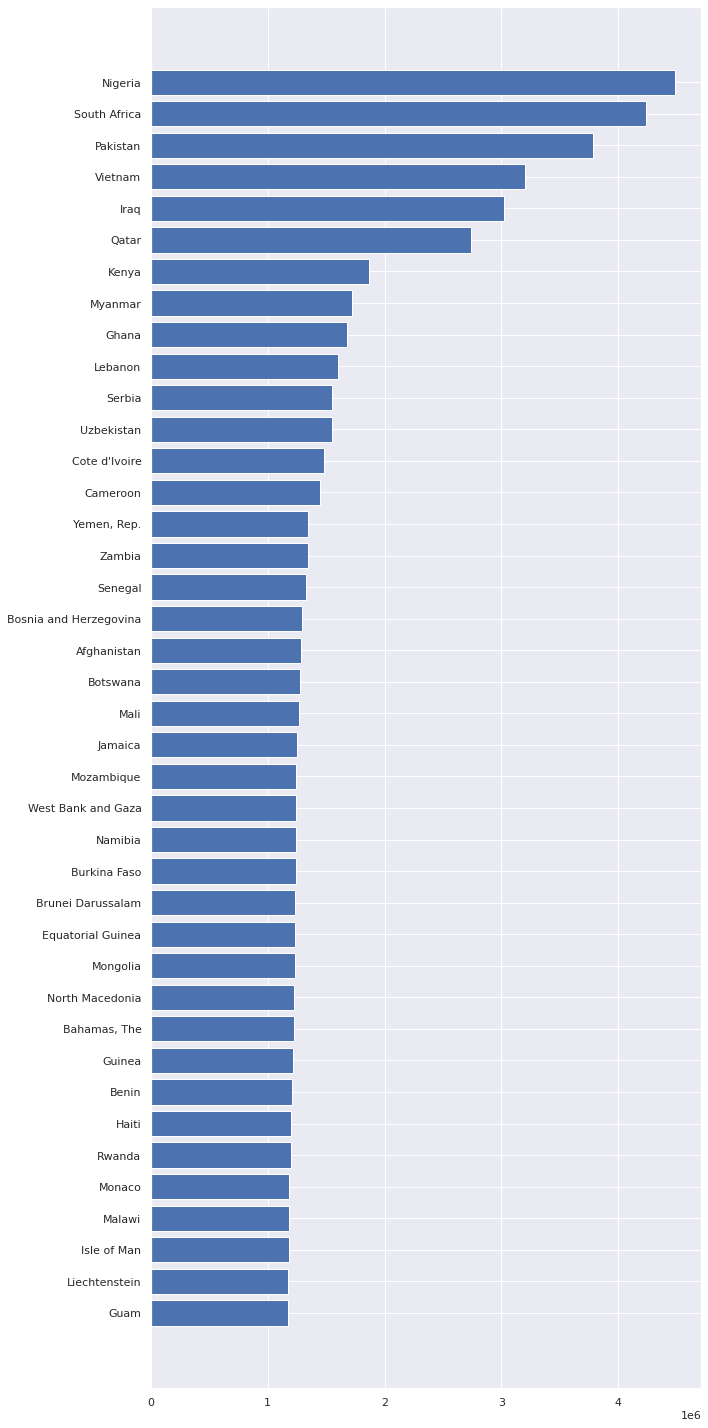

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (10,20))
plt.barh(df_gdp2['Country Name'][:40][::-1], df_gdp2['departures_estimated'][:40][::-1])
plt.tight_layout()

Ahora si que los indices son los mismos en los dos daframes y puedo relleanr bien.

In [33]:
df.iloc[141]

country_name                                                       Nigeria
country_code                                                           NGA
total_pop                                                      1.95875e+08
arrivals                                                         5.265e+06
departures                                                             NaN
latitude                                                                10
longitude                                                                8
arrivals/total                                                  0.00370617
departures/total                                                       NaN
arrivals/population                                              0.0268794
departures/population                                                  NaN
continent_name                                                      Africa
continent_code                                                          AF
destinations             

In [34]:
df['departures'].fillna(df_gdp2['departures_estimated'], inplace = True)

In [35]:
df

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,NaN,1285046.0,33.0000,65.0000,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
1,Albania,ALB,2866376.0,5340000.0,5415000.0,41.0000,20.0000,0.003759,0.004280,1.862980,1.889145,Europe,EU,"[GRC, ITA, GBR, DEU, SVN, AUT, TUR]"
2,Algeria,DZA,42228429.0,2657000.0,5610000.0,28.0000,3.0000,0.001870,0.004434,0.062920,0.132849,Africa,AF,"[DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ..."
3,American Samoa,ASM,64948.0,20200.0,1126325.0,-14.3333,-170.0000,0.000014,NaN,0.311018,NaN,Oceania,OC,[USA]
4,Andorra,AND,1198575.0,3042000.0,1148366.0,42.5000,1.6000,0.002141,NaN,2.538014,NaN,Europe,EU,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,Virgin Islands (U.S.),VIR,106977.0,381000.0,NaN,18.3333,-64.8333,0.000268,NaN,3.561513,NaN,North America,NaN,"[VGB, PRI, USA, AIA, DMA, KNA]"
214,West Bank and Gaza,PSE,4569087.0,606000.0,NaN,32.0000,35.2500,0.000427,NaN,0.132630,NaN,Asia,AS,NaN
215,"Yemen, Rep.",YEM,28498687.0,366700.0,NaN,15.0000,48.0000,0.000258,NaN,0.012867,NaN,Asia,AS,"[ARE, SAU, SOM, DJI, BHR, JOR, IND, EGY, QAT, ..."
216,Zambia,ZMB,17351822.0,1072000.0,NaN,-15.0000,30.0000,0.000755,NaN,0.061780,NaN,Africa,AF,"[NLD, ZWE, MWI, KEN, ZAF, BWA, AGO, ARE, ETH, ..."


In [36]:
df['departures'].isna().sum()

52

Estos son los únicos países de los que no tengo el numero de departures, despues de la estimación.

In [37]:
df.loc[df['departures'].isna()]

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
10,Aruba,ABW,1.058450e+05,1082000.0,NaN,12.5000,-69.9667,0.000762,NaN,10.222495,NaN,North America,NaN,"[VEN, DOM, USA, CAN, COL, PAN, NLD, SUR]"
15,"Bahamas, The",BHS,3.856400e+05,1633000.0,NaN,24.2500,-76.0000,0.001150,NaN,4.234519,NaN,North America,NaN,"[USA, CAN, TCA, CYM, GBR, JAM, PAN, CUB]"
18,Barbados,BRB,2.866410e+05,680000.0,NaN,13.1667,-59.5333,0.000479,NaN,2.372305,NaN,North America,NaN,"[USA, CAN, GBR, ATG, JAM, TTO, DEU, BRA, DMA, ..."
21,Belize,BLZ,3.830710e+05,489000.0,NaN,17.2500,-88.7500,0.000344,NaN,1.276526,NaN,North America,NaN,"[GTM, MEX, HND, USA, SLV]"
26,Bosnia and Herzegovina,BIH,3.323929e+06,1053000.0,NaN,44.0000,18.0000,0.000741,NaN,0.316794,NaN,Europe,EU,"[DEU, SWE, ITA, CHE, SRB, DNK, TUR, SVN, AUT, ..."
27,Botswana,BWA,2.254126e+06,1623000.0,NaN,-22.0000,24.0000,0.001142,NaN,0.720013,NaN,Africa,AF,"[ZAF, ZWE, ZMB, KEN]"
38,Cayman Islands,CYM,1.277125e+07,463000.0,NaN,19.5000,-80.5000,0.000326,NaN,0.036253,NaN,North America,NaN,"[USA, CAN, BHS, CUB, JAM, HND]"
44,Comoros,COM,8.323220e+05,35900.0,NaN,-12.1667,44.2500,0.000025,NaN,0.043132,NaN,Africa,AF,"[KEN, DJI, MDG, TZA, MYT, REU]"
48,Cote d'Ivoire,CIV,2.506923e+07,1965000.0,NaN,8.0000,-5.0000,0.001383,NaN,0.078383,NaN,Africa,AF,"[BFA, BEL, FRA, DZA, MAR, BEN, SEN, GHA, SLE, ..."
55,Djibouti,DJI,9.589200e+05,63000.0,NaN,11.5000,43.0000,0.000044,NaN,0.065699,NaN,Africa,AF,"[ARE, SAU, SOM, FRA, ETH, YEM, COM, KEN, TUR]"


### DAILY DEPARTURES

In [38]:
df['departures'] / 365

0       3520.673973
1      14835.616438
2      15369.863014
3       3085.821918
4       3146.208219
           ...     
213             NaN
214             NaN
215             NaN
216             NaN
217     8183.561644
Name: departures, Length: 211, dtype: float64

In [39]:
df_dailydepartures = pd.concat([df.loc[:,['country_name', 'country_code']], df['departures'] / 365 ], axis = 1)
df_dailydepartures

,country_name,country_code,departures
0,Afghanistan,AFG,3520.673973
1,Albania,ALB,14835.616438
2,Algeria,DZA,15369.863014
3,American Samoa,ASM,3085.821918
4,Andorra,AND,3146.208219
...,...,...,...
213,Virgin Islands (U.S.),VIR,NaN
214,West Bank and Gaza,PSE,NaN
215,"Yemen, Rep.",YEM,NaN
216,Zambia,ZMB,NaN


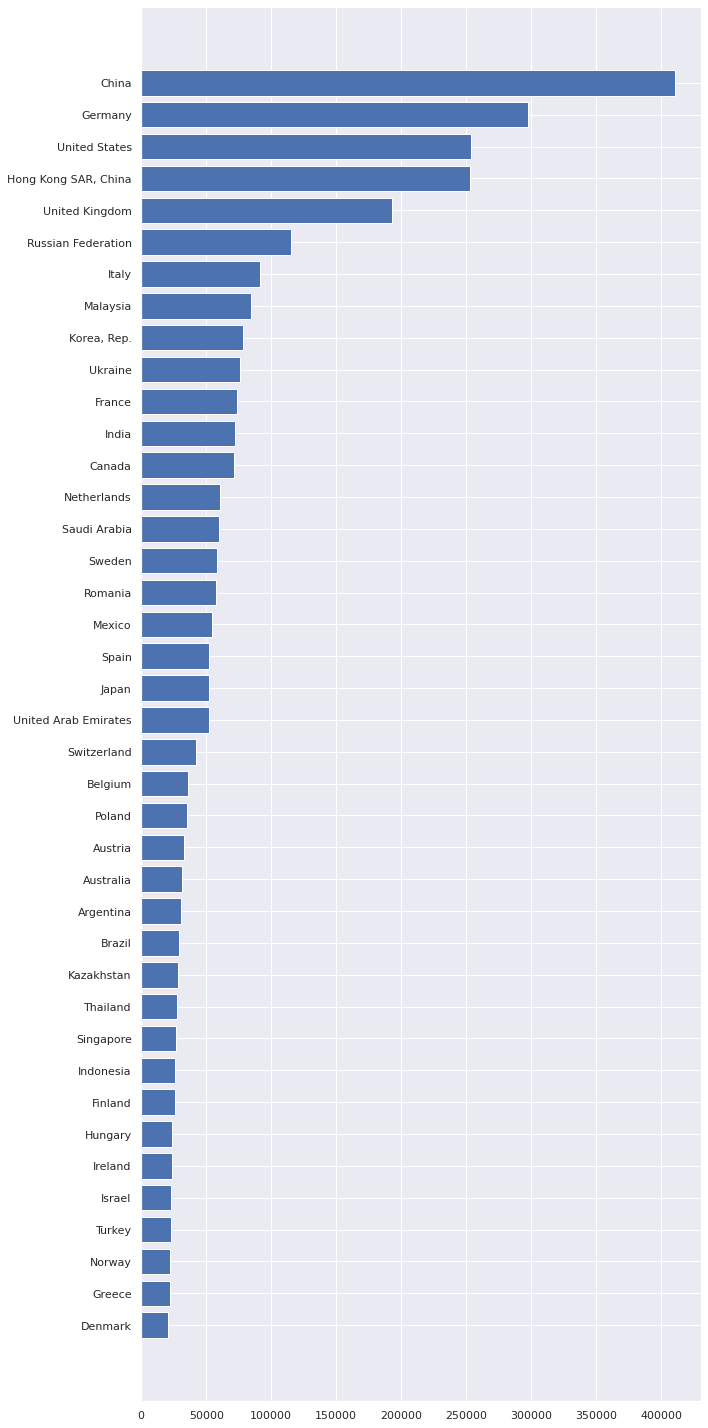

In [40]:
foo = df_dailydepartures.sort_values(by = 'departures', ascending = False)

fig, ax = plt.subplots(1, 1, figsize = (10,20))
plt.barh(foo['country_name'][:40][::-1], foo['departures'][:40][::-1])
plt.tight_layout()

## ARRIVALS

In [41]:
df.head()

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,NaN,1285046.0,33.0000,65.0,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
1,Albania,ALB,2866376.0,5340000.0,5415000.0,41.0000,20.0,0.003759,0.004280,1.862980,1.889145,Europe,EU,"[GRC, ITA, GBR, DEU, SVN, AUT, TUR]"
2,Algeria,DZA,42228429.0,2657000.0,5610000.0,28.0000,3.0,0.001870,0.004434,0.062920,0.132849,Africa,AF,"[DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ..."
3,American Samoa,ASM,64948.0,20200.0,1126325.0,-14.3333,-170.0,0.000014,NaN,0.311018,NaN,Oceania,OC,[USA]
4,Andorra,AND,1198575.0,3042000.0,1148366.0,42.5000,1.6,0.002141,NaN,2.538014,NaN,Europe,EU,NaN


In [42]:
df['arrivals'].isna().sum()

10

In [43]:
df_nan_arrivals = df.loc[df['arrivals'].isna()]
df_nan_arrivals

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,NaN,1285046.0,33.0000,65.0000,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
61,Equatorial Guinea,GNQ,1308974.0,NaN,NaN,2.0000,10.0000,NaN,NaN,NaN,NaN,Africa,AF,"[CMR, MAR, GAB, BEN, ETH, ESP, NGA]"
66,Faroe Islands,FRO,361313.0,NaN,NaN,62.0000,-7.0000,NaN,NaN,NaN,NaN,Europe,EU,"[NOR, DNK]"
77,Gibraltar,GIB,117606.0,NaN,1171110.0,36.1833,-5.3667,NaN,NaN,NaN,NaN,Europe,EU,[GBR]
79,Greenland,GRL,51709098.0,NaN,1213379.0,72.0000,-40.0000,NaN,NaN,NaN,NaN,North America,NaN,"[ISL, DNK, IDN]"
96,Isle of Man,IMN,2786844.0,NaN,NaN,54.2300,-4.5500,NaN,NaN,NaN,NaN,Europe,EU,"[GBR, IRL]"
106,"Korea, Dem. People’s Rep.",PRK,25549819.0,NaN,NaN,40.0000,127.0000,NaN,NaN,NaN,NaN,Asia,AS,"[CHN, MYS, RUS]"
114,Liberia,LBR,4818977.0,NaN,NaN,6.5000,-9.5000,NaN,NaN,NaN,NaN,Africa,AF,"[GHA, SLE, NGA, MAR, CIV, BEL]"
139,Nauru,NRU,32510453.0,NaN,NaN,-0.5333,166.9167,NaN,NaN,NaN,NaN,Oceania,OC,"[AUS, MHL, KIR]"
178,Somalia,SOM,15008154.0,NaN,1127811.0,10.0000,49.0000,NaN,NaN,NaN,NaN,Africa,AF,"[KEN, DJI, ETH, UGA, YEM, ARE]"


Hago lo mismo que con los departures, cojo la mediana de arrivals y pondero por el GDP del pais.

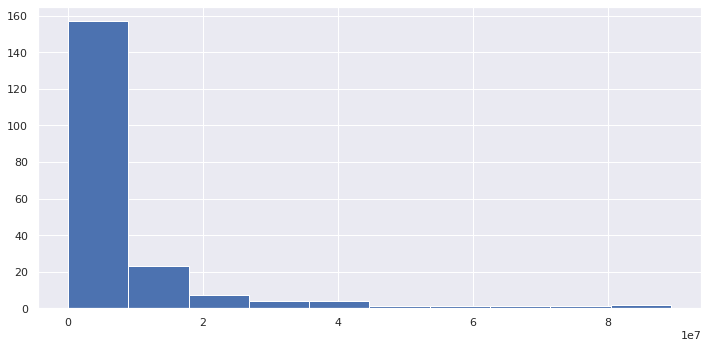

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.hist(df['arrivals'].dropna())
plt.tight_layout()

In [45]:
arrivals_median = np.median(df['arrivals'].dropna())
arrivals_median

1623000.0

In [46]:
df2.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,82.783289,83.120303,83.533457,83.897596,84.171599,84.510171,NaN,NaN,NaN,NaN
1,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,86.428272,87.070576,88.176836,87.342739,89.130121,89.678685,90.273687,NaN,NaN,NaN
2,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.942103,75.244104,77.162305,75.538976,78.741152,79.665635,80.749293,NaN,NaN,NaN
3,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,95.939242,95.962166,96.352930,95.997833,96.649916,96.834184,97.003974,NaN,NaN,NaN
4,Arab World,ARB,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,22.260538,NaN,NaN,30.277130,NaN,NaN,37.165211,NaN,NaN,NaN


Tengo que volver a extraer el gdp porq en el dataframe anterior me habia quedado solo con los valores nan en departures.

In [47]:
df_gdp3 = last_values(extract_indicator(df2, 'GDP (current US$)'))
df_gdp3

,Country Name,Country Code,last_value
0,Arab World,ARB,2.774315e+12
1,Caribbean small states,CSS,7.352354e+10
2,Central Europe and the Baltics,CEB,1.632913e+12
3,Early-demographic dividend,EAR,1.163806e+13
4,East Asia & Pacific,EAS,2.594241e+13
...,...,...,...
259,Virgin Islands (U.S.),VIR,3.855000e+09
260,West Bank and Gaza,PSE,1.461590e+10
261,"Yemen, Rep.",YEM,2.691440e+10
262,Zambia,ZMB,2.672007e+10


Tengo que hacer esto, para que los indices esten bien.

In [48]:
df_gdp3 = df_gdp3.loc[df_gdp3['Country Code'].isin(df['country_code'].values)]
df_gdp3.reset_index(inplace = True, drop = True)
df_gdp3

,Country Name,Country Code,last_value
0,Afghanistan,AFG,1.936297e+10
1,Albania,ALB,1.510250e+10
2,Algeria,DZA,1.737580e+11
3,American Samoa,ASM,6.360000e+08
4,Andorra,AND,3.236544e+09
...,...,...,...
206,Virgin Islands (U.S.),VIR,3.855000e+09
207,West Bank and Gaza,PSE,1.461590e+10
208,"Yemen, Rep.",YEM,2.691440e+10
209,Zambia,ZMB,2.672007e+10


In [49]:
df_gdp3 = df_gdp3.loc[df_gdp3['Country Code'].isin(df_nan_arrivals['country_code'].values)].dropna()
df_gdp3

,Country Name,Country Code,last_value
0,Afghanistan,AFG,1.936297e+10
58,Equatorial Guinea,GNQ,1.343238e+10
63,Faroe Islands,FRO,2.689157e+09
75,Greenland,GRL,2.707147e+09
92,Isle of Man,IMN,6.770533e+09
109,Liberia,LBR,3.264000e+09
134,Nauru,NRU,1.256285e+08
172,Somalia,SOM,4.720727e+09


In [50]:
gdp = df_gdp3['last_value'].values
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0.5, 2))

In [51]:
gdp_normalized = min_max_scaler.fit_transform(gdp.reshape(-1,1))
gdp_normalized

array([[2.        ],
       [1.53757181],
       [0.69988694],
       [0.70128964],
       [1.01812547],
       [0.74470935],
       [0.5       ],
       [0.85829526]])

In [52]:
df_gdp3['GDP_normalized'] = gdp_normalized
df_gdp3['arrivals_estimated'] = gdp_normalized * arrivals_median
df_gdp3['arrivals_estimated'] = df_gdp3['arrivals_estimated'].astype(int)
df_gdp3

,Country Name,Country Code,last_value,GDP_normalized,arrivals_estimated
0,Afghanistan,AFG,1.936297e+10,2.000000,3246000
58,Equatorial Guinea,GNQ,1.343238e+10,1.537572,2495479
63,Faroe Islands,FRO,2.689157e+09,0.699887,1135916
75,Greenland,GRL,2.707147e+09,0.701290,1138193
92,Isle of Man,IMN,6.770533e+09,1.018125,1652417
109,Liberia,LBR,3.264000e+09,0.744709,1208663
134,Nauru,NRU,1.256285e+08,0.500000,811500
172,Somalia,SOM,4.720727e+09,0.858295,1393013


In [53]:
df['arrivals'].fillna(df_gdp3['arrivals_estimated'], inplace = True)
df

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,3246000.0,1285046.0,33.0000,65.0000,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
1,Albania,ALB,2866376.0,5340000.0,5415000.0,41.0000,20.0000,0.003759,0.004280,1.862980,1.889145,Europe,EU,"[GRC, ITA, GBR, DEU, SVN, AUT, TUR]"
2,Algeria,DZA,42228429.0,2657000.0,5610000.0,28.0000,3.0000,0.001870,0.004434,0.062920,0.132849,Africa,AF,"[DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ..."
3,American Samoa,ASM,64948.0,20200.0,1126325.0,-14.3333,-170.0000,0.000014,NaN,0.311018,NaN,Oceania,OC,[USA]
4,Andorra,AND,1198575.0,3042000.0,1148366.0,42.5000,1.6000,0.002141,NaN,2.538014,NaN,Europe,EU,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,Virgin Islands (U.S.),VIR,106977.0,381000.0,NaN,18.3333,-64.8333,0.000268,NaN,3.561513,NaN,North America,NaN,"[VGB, PRI, USA, AIA, DMA, KNA]"
214,West Bank and Gaza,PSE,4569087.0,606000.0,NaN,32.0000,35.2500,0.000427,NaN,0.132630,NaN,Asia,AS,NaN
215,"Yemen, Rep.",YEM,28498687.0,366700.0,NaN,15.0000,48.0000,0.000258,NaN,0.012867,NaN,Asia,AS,"[ARE, SAU, SOM, DJI, BHR, JOR, IND, EGY, QAT, ..."
216,Zambia,ZMB,17351822.0,1072000.0,NaN,-15.0000,30.0000,0.000755,NaN,0.061780,NaN,Africa,AF,"[NLD, ZWE, MWI, KEN, ZAF, BWA, AGO, ARE, ETH, ..."


### DAILY ARRIVALS

Aqui no me hace falta saber los arrivals por dia, solo me interesa la proporcion.

In [54]:
df_arrivals = df.loc[:, ['country_name','country_code','arrivals']]
df_arrivals

,country_name,country_code,arrivals
0,Afghanistan,AFG,3246000.0
1,Albania,ALB,5340000.0
2,Algeria,DZA,2657000.0
3,American Samoa,ASM,20200.0
4,Andorra,AND,3042000.0
...,...,...,...
213,Virgin Islands (U.S.),VIR,381000.0
214,West Bank and Gaza,PSE,606000.0
215,"Yemen, Rep.",YEM,366700.0
216,Zambia,ZMB,1072000.0


In [55]:
df_arrivals['arrivals/total'] = df_arrivals['arrivals'] / np.sum(df_arrivals['arrivals'])
df_arrivals

,country_name,country_code,arrivals,arrivals/total
0,Afghanistan,AFG,3246000.0,0.002280
1,Albania,ALB,5340000.0,0.003750
2,Algeria,DZA,2657000.0,0.001866
3,American Samoa,ASM,20200.0,0.000014
4,Andorra,AND,3042000.0,0.002136
...,...,...,...,...
213,Virgin Islands (U.S.),VIR,381000.0,0.000268
214,West Bank and Gaza,PSE,606000.0,0.000426
215,"Yemen, Rep.",YEM,366700.0,0.000258
216,Zambia,ZMB,1072000.0,0.000753


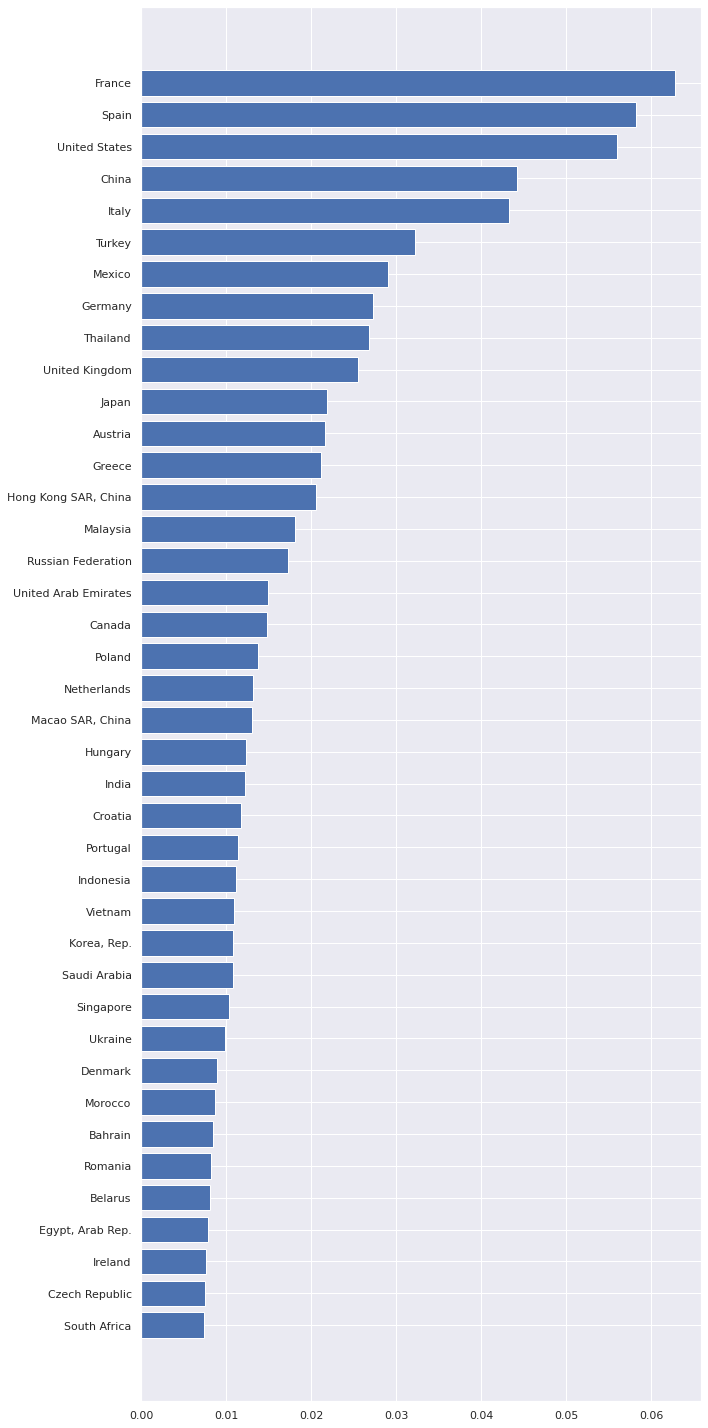

In [56]:
foo = df_arrivals.sort_values(by = 'arrivals/total', ascending = False)

fig, ax = plt.subplots(1, 1, figsize = (10,20))
plt.barh(foo['country_name'][:40][::-1], foo['arrivals/total'][:40][::-1])
plt.tight_layout()

In [57]:
df.head()

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,3246000.0,1285046.0,33.0000,65.0,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
1,Albania,ALB,2866376.0,5340000.0,5415000.0,41.0000,20.0,0.003759,0.004280,1.862980,1.889145,Europe,EU,"[GRC, ITA, GBR, DEU, SVN, AUT, TUR]"
2,Algeria,DZA,42228429.0,2657000.0,5610000.0,28.0000,3.0,0.001870,0.004434,0.062920,0.132849,Africa,AF,"[DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ..."
3,American Samoa,ASM,64948.0,20200.0,1126325.0,-14.3333,-170.0,0.000014,NaN,0.311018,NaN,Oceania,OC,[USA]
4,Andorra,AND,1198575.0,3042000.0,1148366.0,42.5000,1.6,0.002141,NaN,2.538014,NaN,Europe,EU,NaN


In [58]:
df['destinations'].isna().sum()

6

In [59]:
df.loc[df['destinations'].isna()]

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
4,Andorra,AND,1198575.0,3042000.0,1148366.0,42.5000,1.6000,0.002141,NaN,2.538014,NaN,Europe,EU,NaN
116,Liechtenstein,LIE,3225167.0,85300.0,1180814.0,47.1667,9.5333,0.000060,NaN,0.026448,NaN,Europe,EU,NaN
138,Namibia,NAM,2448255.0,1499000.0,NaN,-22.0000,17.0000,0.001055,NaN,0.612273,NaN,Africa,AF,NaN
167,San Marino,SMR,15442905.0,84000.0,NaN,43.7667,12.4167,0.000059,NaN,0.005439,NaN,Europe,EU,NaN
189,Syrian Arab Republic,SYR,16906283.0,5070000.0,6259000.0,35.0000,38.0000,0.003569,0.004947,0.299889,0.370217,Asia,AS,NaN
214,West Bank and Gaza,PSE,4569087.0,606000.0,NaN,32.0000,35.2500,0.000427,NaN,0.132630,NaN,Asia,AS,NaN


Son paises que no tienen aerpuerto...no entran en mi modelo.

## FINAL ASSUMPTION

Podria si tengo nan en un pais en departures, igualarlo al arrivals. Y si tampoco tiene arrivals si que podría hacer lo de coger la media y multipplicarlo por su GDP ponderado al total de GDP's. Porque así no depende de los paises en los que tengo nan.

In [60]:
df = pd.read_pickle('/Users/agm/Documents/KSchool/TFM/data_out/fulldataset_agm.gpickle')
df

FileNotFoundError: [Errno 2] No such file or directory: '/Users/agm/Documents/KSchool/TFM/data_out/fulldataset_agm.gpickle'

Borro los paises que no tienen aerpuerto, no van a entrar en mi modelo. Ya que si hay una enfermedad en ese pais, no se va a poder transmitir a otros.

In [ ]:
df.dropna(subset = ['destinations'], inplace = True)
df.reset_index(drop = True, inplace = True)

De estos paises tendré que estimar los arrivals con el GDP...porque si tienen aeropuertos pero no tienen datos.

In [ ]:
df.loc[df['arrivals'].isna()]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.hist(df['arrivals'].dropna())
plt.tight_layout()

In [ ]:
arrivals_median = np.median(df['arrivals'].dropna())
arrivals_median

In [ ]:
df_ind = pd.read_csv('/Users/agm/Documents/KSchool/TFM/datasets/WDI_csv/WDIData.csv')
df_gdp = last_values(extract_indicator(df_ind, 'GDP per capita, PPP (constant 2011 international $)'))
df_gdp2 = last_values(extract_indicator(df_ind, 'GDP (current US$)'))

In [ ]:
df_gdp.loc[df_gdp['Country Code'].isin(df.loc[df['arrivals'].isna()]['country_code'])]

No voy a poder tener los arrivals de Gibraltar ni Korea, porq no tengo sus GDP

In [ ]:
df_gdp2.loc[df_gdp['Country Code'].isin(df.loc[df['arrivals'].isna()]['country_code'])]

In [ ]:
df_gdp2 = df_gdp2[df_gdp2['Country Code'].isin(df['country_code'])].reset_index(drop = True)
df_gdp2

In [ ]:
df.iloc[202]

Normalizo enre 0,5 y 2 los valores de GDP. Es mejor normalizar respecto al subconjunto, porq si no me quedan valores muy pequeños para todos.

In [ ]:
foo = df.loc[df['arrivals'].isna()]
df_gdp2 = df_gdp2.iloc[foo.index].dropna()
df_gdp2

In [ ]:
gdp = df_gdp2['last_value'].values

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0.5, 2))
gdp_normalized = min_max_scaler.fit_transform(gdp.reshape(-1,1))

In [ ]:
df_gdp2['GDP_normalized'] = gdp_normalized
df_gdp2

Los valores del GDP normalizado para los que arrivals es nan

Veo como realmente los paises de los que no tenia arrivals, son paises con poco GDP.

Añado la nueva columna

In [ ]:
df_gdp2['arrivals_estimated'] = df_gdp2['GDP_normalized'] * arrivals_median
df_gdp2

In [ ]:
df['arrivals'].fillna(df_gdp2['arrivals_estimated'], inplace = True)
df

Asigno el valor de arrivals a departures si hay nan

In [ ]:
df.loc[df['departures'].isna(), 'departures'] = df['arrivals']

In [ ]:
df

In [ ]:
df['arrivals'].isna().sum()

In [ ]:
df.dropna(subset = ['arrivals'], inplace = True)
df['arrivals'].isna().sum()

## FINAL DATASET

In [61]:
df_move = df.loc[:, ['country_name', 'country_code']]
df_move

,country_name,country_code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND
...,...,...
213,Virgin Islands (U.S.),VIR
214,West Bank and Gaza,PSE
215,"Yemen, Rep.",YEM
216,Zambia,ZMB


In [62]:
df_move['arrivals/day'] = df['arrivals'] / 365
df_move['departures/day'] = df['departures'] / 365
df_move

,country_name,country_code,arrivals/day,departures/day
0,Afghanistan,AFG,8893.150685,3520.673973
1,Albania,ALB,14630.136986,14835.616438
2,Algeria,DZA,7279.452055,15369.863014
3,American Samoa,ASM,55.342466,3085.821918
4,Andorra,AND,8334.246575,3146.208219
...,...,...,...,...
213,Virgin Islands (U.S.),VIR,1043.835616,NaN
214,West Bank and Gaza,PSE,1660.273973,NaN
215,"Yemen, Rep.",YEM,1004.657534,NaN
216,Zambia,ZMB,2936.986301,NaN


In [63]:
foo = df_move.sort_values(by='arrivals/day', ascending=False)
foo

,country_name,country_code,arrivals/day,departures/day
69,France,FRA,244717.808219,73736.986301
180,Spain,ESP,226775.342466,52372.602740
207,United States,USA,218481.972603,253600.000000
42,China,CHN,172328.767123,410191.780822
98,Italy,ITA,168677.260274,91361.917808
...,...,...,...,...
96,Isle of Man,IMN,NaN,NaN
106,"Korea, Dem. People’s Rep.",PRK,NaN,NaN
114,Liberia,LBR,NaN,NaN
139,Nauru,NRU,NaN,NaN


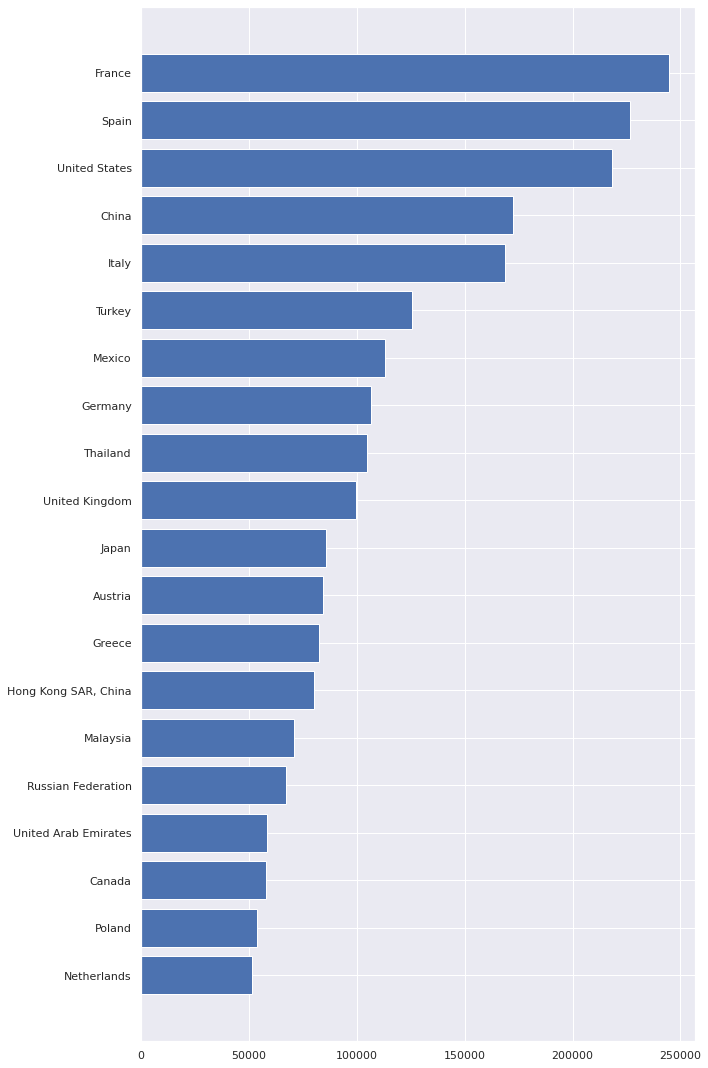

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plt.barh(foo['country_name'][:20][::-1],
         foo['arrivals/day'][:20][::-1])
plt.tight_layout()

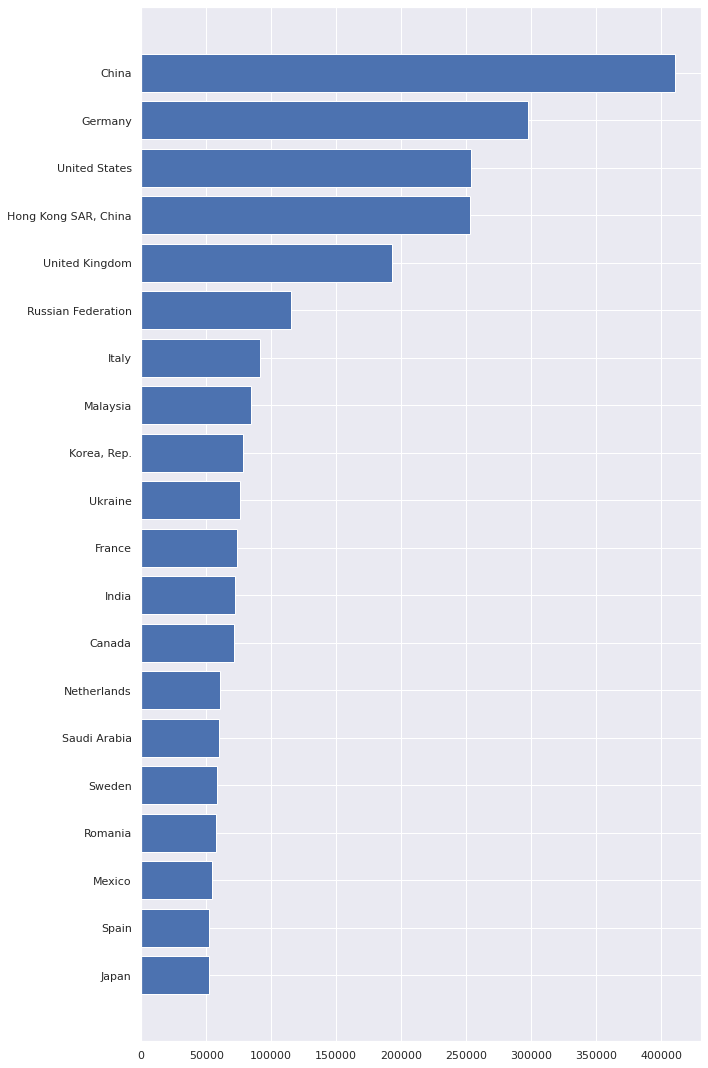

In [65]:
foo = df_move.sort_values(by='departures/day', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plt.barh(foo['country_name'][:20][::-1],
         foo['departures/day'][:20][::-1])
plt.tight_layout()

No me hace falta saber cuantos pasajeros llegan al dia a cada pais, si no la proporcion respecto al total. Las salidas desde cada pais si me interesan.

In [66]:
df_move.head()

,country_name,country_code,arrivals/day,departures/day
0,Afghanistan,AFG,8893.150685,3520.673973
1,Albania,ALB,14630.136986,14835.616438
2,Algeria,DZA,7279.452055,15369.863014
3,American Samoa,ASM,55.342466,3085.821918
4,Andorra,AND,8334.246575,3146.208219


In [67]:
df_move['proportion arrivals'] = df_move['arrivals/day'] / np.sum(df_move['arrivals/day'])
df_move.head()

,country_name,country_code,arrivals/day,departures/day,proportion arrivals
0,Afghanistan,AFG,8893.150685,3520.673973,0.002280
1,Albania,ALB,14630.136986,14835.616438,0.003750
2,Algeria,DZA,7279.452055,15369.863014,0.001866
3,American Samoa,ASM,55.342466,3085.821918,0.000014
4,Andorra,AND,8334.246575,3146.208219,0.002136


In [68]:
df_move.loc[df_move['country_code'] == 'ESP']

,country_name,country_code,arrivals/day,departures/day,proportion arrivals
180,Spain,ESP,226775.342466,52372.60274,0.058133


In [69]:
countrycode_to_proparriv = pd.Series(
    df_move['proportion arrivals'].values, index=df_move['country_code']).to_dict()
countrycode_to_proparriv

{'AFG': 0.002279732889470416,
 'ALB': 0.003750392368999391,
 'DZA': 0.0018660660158111202,
 'ASM': 1.4186877500709307e-05,
 'AND': 0.0021364594731266193,
 'AGO': 0.0001531059057007242,
 'ATG': 0.00018892425978667344,
 'ARG': 0.004875510079699209,
 'ARM': 0.0011602337441174145,
 'ABW': 0.0007599109631568054,
 'AUS': 0.0064936568995820915,
 'AUT': 0.021642713715933563,
 'AZE': 0.0018492103197706735,
 'BHS': 0.0011468896514187277,
 'BHR': 0.008459452450299188,
 'BGD': 0.0007205810057290965,
 'BRB': 0.0004775780544793232,
 'BLR': 0.00807781139911674,
 'BEL': 0.0064044621747013945,
 'BLZ': 0.0003434348068241015,
 'BEN': 0.00020718459716382405,
 'BMU': 0.00019805442847524874,
 'BTN': 0.0001924358631284332,
 'BOL': 0.0008020502032579223,
 'BIH': 0.000739543663774599,
 'BWA': 0.001139866444735208,
 'BRA': 0.004650065145158234,
 'VGB': 0.00013484556832357364,
 'BRN': 0.00019524514580184096,
 'BGR': 0.006512619557627594,
 'BFA': 0.00010113417624268021,
 'BDI': 0.00020999387983723183,
 'CPV': 0.0

In [70]:
countrycode_to_departures = pd.Series(
    df_move['departures/day'].values, index=df_move['country_code']).to_dict()
countrycode_to_departures

{'AFG': 3520.67397260274,
 'ALB': 14835.616438356165,
 'DZA': 15369.86301369863,
 'ASM': 3085.821917808219,
 'AND': 3146.2082191780823,
 'AGO': 8.219178082191782,
 'ATG': 3108.4520547945203,
 'ARG': 30493.15068493151,
 'ARM': 4446.575342465753,
 'ABW': nan,
 'AUS': 31241.095890410958,
 'AUT': 32556.164383561645,
 'AZE': 10736.986301369863,
 'BHS': nan,
 'BHR': 7857.534246575343,
 'BGD': 4000.0,
 'BRB': nan,
 'BLR': 2290.4109589041095,
 'BEL': 35884.931506849316,
 'BLZ': nan,
 'BEN': 3127.868493150685,
 'BMU': 526.027397260274,
 'BTN': 3539.2246575342465,
 'BOL': 2904.109589041096,
 'BIH': nan,
 'BWA': nan,
 'BRA': 29117.80821917808,
 'VGB': 380.82191780821915,
 'BRN': 3399.0383561643835,
 'BGR': 18353.424657534248,
 'BFA': 3116.956164383562,
 'BDI': 95.89041095890411,
 'CPV': 3969.115068493151,
 'KHM': 5465.753424657534,
 'CMR': 3190.449315068493,
 'CAN': 71323.28767123287,
 'CYM': nan,
 'CAF': 104.10958904109589,
 'TCD': 142.46575342465752,
 'CHL': 10479.452054794521,
 'CHN': 410191.7

In [71]:
len(countrycode_to_proparriv), len(df_move)

(211, 211)

Ya tengo la probabilidad de que un arrival sea al pais j. Ahora tengo que normalizar para los posibles destinos de cada pais i.

In [72]:
df.head()

,country_name,country_code,total_pop,arrivals,departures,latitude,longitude,arrivals/total,departures/total,arrivals/population,departures/population,continent_name,continent_code,destinations
0,Afghanistan,AFG,37172386.0,3246000.0,1285046.0,33.0000,65.0,NaN,NaN,NaN,NaN,Asia,AS,"[IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]"
1,Albania,ALB,2866376.0,5340000.0,5415000.0,41.0000,20.0,0.003759,0.004280,1.862980,1.889145,Europe,EU,"[GRC, ITA, GBR, DEU, SVN, AUT, TUR]"
2,Algeria,DZA,42228429.0,2657000.0,5610000.0,28.0000,3.0,0.001870,0.004434,0.062920,0.132849,Africa,AF,"[DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ..."
3,American Samoa,ASM,64948.0,20200.0,1126325.0,-14.3333,-170.0,0.000014,NaN,0.311018,NaN,Oceania,OC,[USA]
4,Andorra,AND,1198575.0,3042000.0,1148366.0,42.5000,1.6,0.002141,NaN,2.538014,NaN,Europe,EU,NaN


In [73]:
df.loc[:,'destinations']

0               [IND, PAK, ARE, IRN, TUR, AZE, KWT, TJK]
1                    [GRC, ITA, GBR, DEU, SVN, AUT, TUR]
2      [DEU, FRA, TUR, CIV, ESP, JOR, LBN, MLI, BEL, ...
3                                                  [USA]
4                                                    NaN
                             ...                        
213                       [VGB, PRI, USA, AIA, DMA, KNA]
214                                                  NaN
215    [ARE, SAU, SOM, DJI, BHR, JOR, IND, EGY, QAT, ...
216    [NLD, ZWE, MWI, KEN, ZAF, BWA, AGO, ARE, ETH, ...
217                  [ZMB, KEN, ZAF, BWA, ETH, MWI, TZA]
Name: destinations, Length: 211, dtype: object

Puedo hacer una lista de diccionarios y luego añadirla al df.

<AxesSubplot:>

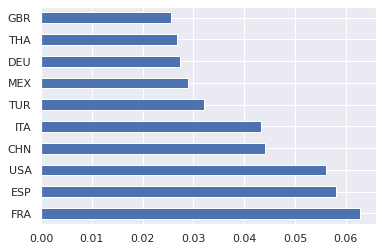

In [74]:
foo = pd.Series(countrycode_to_proparriv).sort_values(ascending = False)
foo[:10].plot(kind='barh')

El diccionario si q esta bien, tendrían que llegar más personas a francia y españa.

<AxesSubplot:>

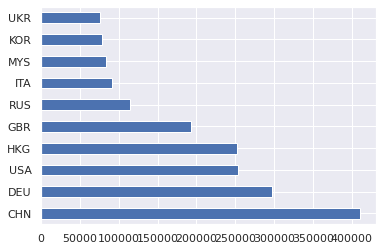

In [75]:
foo = pd.Series(countrycode_to_departures).sort_values(ascending = False)
foo[:10].plot(kind='barh')

In [76]:
l_1 = []
l_2 = []

for country in df.iterrows():
    # print(country[1]['destinations'])
    country_destinations = country[1]['destinations']
    country_destinations_2 = country_destinations.copy()
    for i in country_destinations:
        if i not in countrycode_to_proparriv:
            # no meto en la lista un pais del que no tenga la proporcion
            country_destinations_2.remove(i)
    #l.append({x: countrycode_to_proparriv[x] for x in country_destinations_2})
    d = {x: countrycode_to_proparriv[x] for x in country_destinations_2}
    sum_prob = np.sum(list(d.values()))
    d_1 = {k: v / sum_prob for k, v in d.items()}
    l_1.append(d_1)
    l_2.append({k: int(v*countrycode_to_departures[country[1]['country_code']]) for k, v in d_1.items()})

AttributeError: 'float' object has no attribute 'copy'

In [ ]:
df['destinations'] = l_1
df['departures/day'] = l_2
df

Compruebo que todas las probabilidades suman 1.

In [ ]:
l = []

for i in range(len(df)):
    l.append(np.sum(list(df.iloc[i, df.columns.get_loc('destinations')  ].values())))
l

In [ ]:
import json
with open('/Users/agm/Documents/KSchool/TFM/data_out/alpha3_to_country.txt') as file:
    alpha3_to_country = json.load(file)

In [ ]:
d = df.loc[df['country_code'] == 'CHN', 'destinations'].item()
d = {alpha3_to_country[k]: v for k,v in d.items()}
foo = pd.Series(d)
foo.sort_values(ascending = False, inplace = True)
fig, ax = plt.subplots(1, 1, figsize = (10,15))
plt.barh(foo.index[:20][::-1], foo.values[:20][::-1])
plt.tight_layout()

In [ ]:
d = df.loc[df['country_code'] == 'ESP', 'departures/day'].item()
d = {alpha3_to_country[k]: v for k,v in d.items()}
d

In [ ]:
foo = pd.Series(d)
foo

In [ ]:
foo.sort_values(ascending = False, inplace = True)

Veo como desde españa va mucha gente a china, estados unidos.. porque reciben mucha gente a nivel global, pero realmente estan muy lejos y no es reallista, habría que ponderar en relación a la distáncia entre paises....

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,15))
plt.barh(foo.index[:20][::-1], foo.values[:20][::-1])
plt.tight_layout()

In [ ]:
df.head()

In [ ]:
G_country = nx.read_gpickle("/Users/agm/Documents/KSchool/TFM/data_out/routes_countries.gpickle")

In [ ]:
df.shape

In [ ]:
len(G_country.nodes)

Hago un nuevo grafo, porque hay paises que me han desaparecido del grafo, porq no tenía información para modelar, no tenía o GDP o arrivals/departures.

In [ ]:
H = nx.DiGraph()

for index, country in df.iterrows():
    destinations = country['departures/day']
    for k, v in destinations.items():
        H.add_edge(country['country_code'], k, people=v)

In [ ]:
len(H.nodes)

In [ ]:
OD_matrix = nx.attr_matrix(H, edge_attr='people', rc_order = df['country_code'] )
OD_matrix

Compruebo que la suma de una fila coincide con el numero de departures para un pais.

In [ ]:
i= 170
print(np.sum(OD_matrix[i,:]))
print(df.iloc[i, df.columns.get_loc('departures')] / 365)

In [ ]:
df.loc[df['country_code'] == 'ESP']

In [ ]:
df.iloc[170]

In [ ]:
np.save('/Users/agm/Documents/KSchool/TFM/data_out/od_matrix.npy',OD_matrix)

In [ ]:
df.reset_index(drop = True, inplace = True)

Pongo a mano si está la poblacion de estos paises.

In [ ]:
df.loc[df['population'].isna()]

In [ ]:
df_populations = pd.read_csv('~/Documents/kschool/TFM/datasets/country_populations.csv')
df_populations

In [ ]:
with open('/Users/agm/Documents/kschool/TFM/data_out/alpha2_to_alpha3.txt', 'r') as file:
    alpha2_to_alpha3 = json.load(file)

In [ ]:
df_populations['cca2'] = df_populations['cca2'].map(alpha2_to_alpha3)
df_populations

In [ ]:
df_populations.loc[df_populations['cca2'] == 'ESP']

In [ ]:
df_populations['pop2020'] = df_populations['pop2020'] * 1000

In [ ]:
df_populations.loc[df_populations['cca2'] == 'ESP']

In [ ]:
df.head()

In [ ]:
import math
x = 322
math.isnan(x)

In [ ]:
for index, row in df.iterrows():
    if math.isnan(row["population"]):
        df.loc[
            df["country_code"] == row["country_code"], "population"
        ] = df_populations.loc[df_populations["cca2"] == row["country_code"], "pop2020"].item()
df.head()

In [ ]:
df.to_pickle('/Users/agm/Documents/KSchool/TFM/data_out/fulldataset_agm_rev1.gpickle')

In [ ]:
df.to_pickle('/Users/agm/Documents/KSchool/TFM/data_out/fulldataset_agm_rev2.gpickle', protocol = 2)